### TODO Recording:

- Go to https://colab.research.google.com
- Sign in with the account
- Show that you are using the GPU runtime
- Open up the folder icon on the left
- Upload the Tweets.csv file to this folder

In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

from wordcloud import WordCloud
from tensorflow.keras import layers, models, losses, Sequential, optimizers, metrics

In [2]:
import tensorflow

print(tensorflow.__version__)

2.15.0


In [3]:
import keras

print(keras.__version__)

2.15.0


Upgrading seaborn to latest version

In [4]:
pip install seaborn -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [6]:
import seaborn as sns

print(sns.__version__)

0.13.0


Loading the  data.
Dataset link-
https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset/data?select=Tweets.csv

In [5]:
tweets_data = pd.read_csv("Tweets.csv")

tweets_data.sample(10)

,textID,text,selected_text,sentiment
13433,bcb26151fc,well gracias haha and why is that? the plays?,s haha,positive
11761,4177a4f15e,still no pool key. wth. it`s even hot out today.,it`s even hot,negative
1053,b57188597f,hhahaa! its well strange just woke up to ...,hhahaa! its well strange just woke up to an...,neutral
24165,41daf68fa0,tut tut. Isn`t charging just fun. Thr new pal...,fun.,positive
22849,f398ee6a60,I miss you,I miss you,negative
22575,01fb6a1ad7,I didn`t get a lot of sleep myself last night...,good,positive
20850,3b53590c68,More #ecomonday and me _fischer Now I`ll go...,More #ecomonday and me _fischer Now I`ll go...,neutral
168,e56eeb4968,Few Bevvies 2day in twn..great on a day off!!,great,positive
5677,b914073e50,Not sure yet... they said we`ll see,Not sure yet... they said we`ll see,neutral
17855,0aaf4fbf71,Ill in bed my stomach is killing me,Ill in bed my stomach is killing me,negative


Dataset info is obtained

In [7]:
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


Null values are checked. Only one instance was found

In [8]:
tweets_data.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

Null value instance is dropped

In [9]:
tweets_data = tweets_data.dropna()

tweets_data.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

Duplicacy checked. None was found

In [10]:
tweets_data.duplicated().sum()

0

Dropping irrelevant columns

In [11]:
tweets_data = tweets_data.drop(columns = ["selected_text", "textID"])

tweets_data.sample(10)

,text,sentiment
6094,had fun at wango tangooo!,positive
14030,*HUGS you* awwww......i`m sorry you are feel...,negative
17510,oh noo.. i cant see it,negative
7664,My dream was about hanging out with all my fr...,neutral
20171,I don`t wanna go to work,negative
25745,feels the same way about cherry-flavored items...,neutral
5766,it`s not working here,negative
16093,morning!!!! happy #juddday,positive
14501,"Hey Sam, happy mothers day",positive
12720,was late,negative


Target balance is checked

In [12]:
tweets_data["sentiment"].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

Neutral class counts is highest

<Axes: xlabel='sentiment', ylabel='count'>

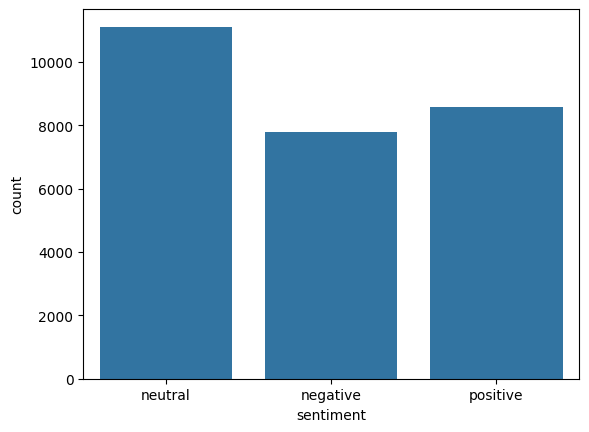

In [13]:
import seaborn as sns

sns.countplot(data = tweets_data, x = "sentiment")

Checking word counts for each instance of tweets

In [16]:
tweets_data["word_count"] = tweets_data["text"].apply(lambda x: len(str(x).split(" ")))

tweets_data[["text", "word_count"]].sample(10)

,text,word_count
26426,hahaha probably not sorry. We`ve got some th...,24
24955,happy mother`s day to all the moms out there. ...,16
1914,feel better! c`s been teething all week & i...,14
20620,Britain`s Got Talent? Such a cute little girl...,22
18211,is a lil sad bc I wont be able toeat a hot dog...,23
20803,No more Mtn. Dew in mini-fridge.,6
10327,I read somewhere they were restoring the nam...,14
14650,MY best `thing` on the planet,6
10169,what`s the deal.,5
11210,_MCR yeahh me tOo haha the mine is Mariel i ...,25


Mean word count is calculated for each class.Negative class word count mean is slightly higher.

In [17]:
tweets_data.groupby("sentiment")["word_count"].mean()

sentiment
negative    14.244313
neutral     13.207610
positive    14.100210
Name: word_count, dtype: float64

In [18]:
tweets_data.groupby("sentiment")["word_count"].median()

sentiment
negative    13.0
neutral     12.0
positive    13.0
Name: word_count, dtype: float64

Word count distribution is checked with histogram and boxplot and word count mean and median seems to be very close for all the classes

<Axes: xlabel='word_count', ylabel='Count'>

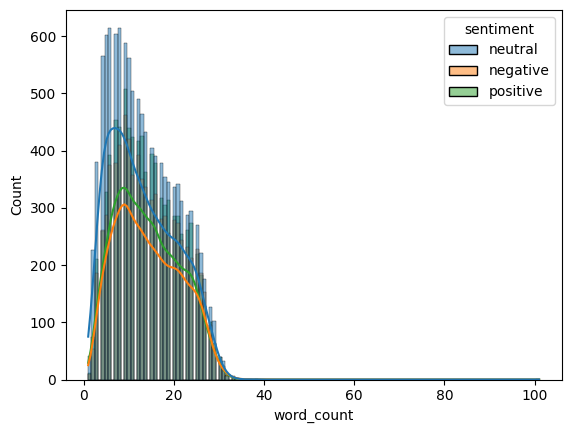

In [27]:
sns.histplot(data = tweets_data, x = "word_count", hue = "sentiment", kde = True)

<Axes: ylabel='word_count'>

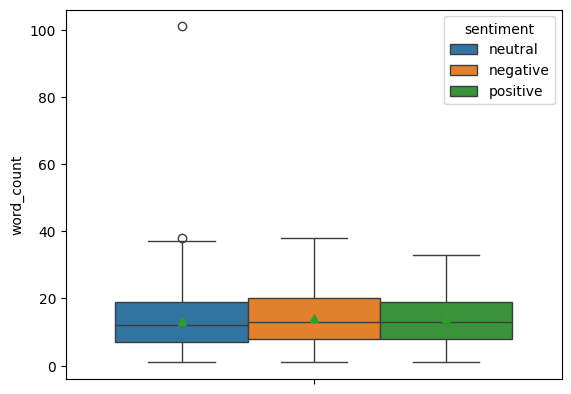

In [26]:
sns.boxplot(data = tweets_data, y = "word_count", hue = "sentiment", showmeans = True)

Downloading stopwords and viewing all the stop words

In [28]:
from nltk.corpus import stopwords

nltk.download("stopwords")

stop_words = stopwords.words("english")

print(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data]   Unzipping corpora/stopwords.zip.


In [50]:
import string

def custom_standardization(input_data):

    # Convert to lowercase
    lowercase = tf.strings.lower(input_data)

    # Remove URLs
    stripped_urls = tf.strings.regex_replace(lowercase, r"https?://\S+|www\.\S+", "")

    # Remove email addresses
    stripped_symbol = tf.strings.regex_replace(stripped_urls, "\S*@\S*\s?", "")

    # Remove text in angular brackets (usually HTML tags)
    stripped_brackets = tf.strings.regex_replace(stripped_symbol, "<.*?>+", "")

    # Remove any square brackets and leave the text within square brackets
    stripped_brackets = tf.strings.regex_replace(stripped_brackets, "\[|\]", "")

    # Matches alphanumeric characters with digits and remove those
    stripped_digits = tf.strings.regex_replace(stripped_brackets, "\w*\d\w*", "")

    # Remove stopwords
    stripped_stopwords = tf.strings.regex_replace(stripped_digits, r"\b(?:{})\b".format("|".join(stop_words)), "")

    # Replace multiple whitespaces with a single whitespace
    stripped_whitespace_chars = tf.strings.regex_replace(stripped_stopwords, "\s+", " ")

    # Remove non-alphabet characters
    return tf.strings.regex_replace(stripped_whitespace_chars ,r"[^a-zA-Z\s]+" ,"")

few texts are cleaned using the clean_text function..url is removed here. Stopwords are removed in all cases below

In [42]:
tweets_data["text"][5]

'http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth'

In [43]:
custom_standardization(tweets_data["text"][5]).numpy()

b'  shameless plugging best rangers forum earth'

Digits , brackets, punctuations, stopwords are removed

In [44]:
tweets_data["text"][20]

' oh Marly, I`m so sorry!!  I hope you find her soon!! <3 <3'

In [45]:
custom_standardization(tweets_data["text"][20]).numpy()

b' oh marly  sorry hope find soon  '

@ symbol is removed

In [46]:
tweets_data["text"][527]

'i am living in ignorance  :@'

In [47]:
custom_standardization(tweets_data["text"][527]).numpy()

b' living ignorance '

Brackets with enclosed text and url is removed

In [48]:
tweets_data["text"][11827]

'My Degree  [Tear] happy moment!  http://mypict.me/1ZpF'

In [49]:
custom_standardization(tweets_data["text"][11827]).numpy()

b' degree tear happy moment '

Now we are cleaning messages by applying  custom standardization. This steps are for visualising word cloud and  not required for classification task

In [51]:
tweets_data["cleaned_text"] = tweets_data["text"].apply(custom_standardization)

tweets_data

,text,sentiment,word_count,cleaned_text
0,"I`d have responded, if I were going",neutral,8,"tf.Tensor(b' responded going', shape=(), dtyp..."
1,Sooo SAD I will miss you here in San Diego!!!,negative,11,"tf.Tensor(b' sooo sad miss san diego', shape=(..."
2,my boss is bullying me...,negative,5,"tf.Tensor(b' boss bullying ', shape=(), dtype=..."
3,what interview! leave me alone,negative,6,"tf.Tensor(b' interview leave alone', shape=(),..."
4,"Sons of ****, why couldn`t they put them on t...",negative,15,tf.Tensor(b' sons put releases already bough...
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,18,tf.Tensor(b' wish could come see u denver husb...
27477,I`ve wondered about rake to. The client has ...,negative,26,tf.Tensor(b' wondered rake client made clear...
27478,Yay good for both of you. Enjoy the break - y...,positive,24,tf.Tensor(b' yay good enjoy break probably n...
27479,But it was worth it ****.,positive,8,"tf.Tensor(b' worth ', shape=(), dtype=string)"


Converting string in tensor form to plain text

In [52]:
# Define a function to convert tensor to string
def tensor_to_string(tensor):
    return tensor.numpy().decode("utf-8")  # Assuming utf-8 encoding

# Apply the function to the DataFrame column
tweets_data["cleaned_text"] = tweets_data["cleaned_text"].apply(tensor_to_string)

tweets_data

,text,sentiment,word_count,cleaned_text
0,"I`d have responded, if I were going",neutral,8,responded going
1,Sooo SAD I will miss you here in San Diego!!!,negative,11,sooo sad miss san diego
2,my boss is bullying me...,negative,5,boss bullying
3,what interview! leave me alone,negative,6,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,15,sons put releases already bought
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,18,wish could come see u denver husband lost job...
27477,I`ve wondered about rake to. The client has ...,negative,26,wondered rake client made clear net force...
27478,Yay good for both of you. Enjoy the break - y...,positive,24,yay good enjoy break probably need hectic w...
27479,But it was worth it ****.,positive,8,worth


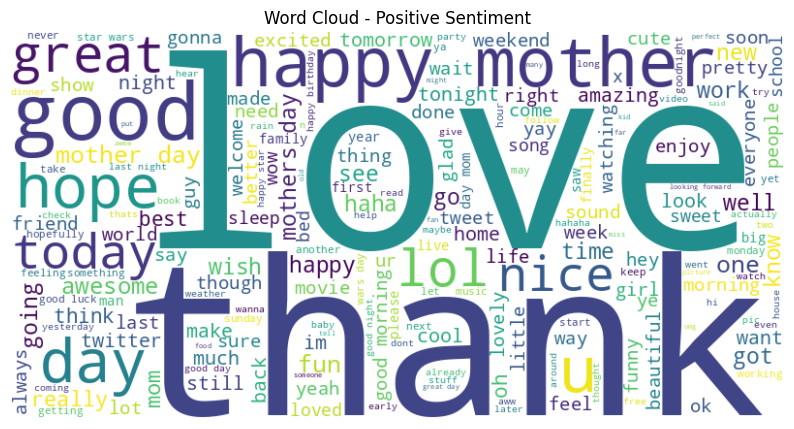

In [53]:
# Extract the text from positive sentiment tweets
positive_tweets = tweets_data[tweets_data["sentiment"] == "positive"]["cleaned_text"]

# Concatenate all the positive sentiment tweets into a single string
positive_text = " ".join(positive_tweets)

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color = "white").generate(positive_text)

# Plot the WordCloud
plt.figure(figsize = (10, 6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Sentiment")
plt.show()

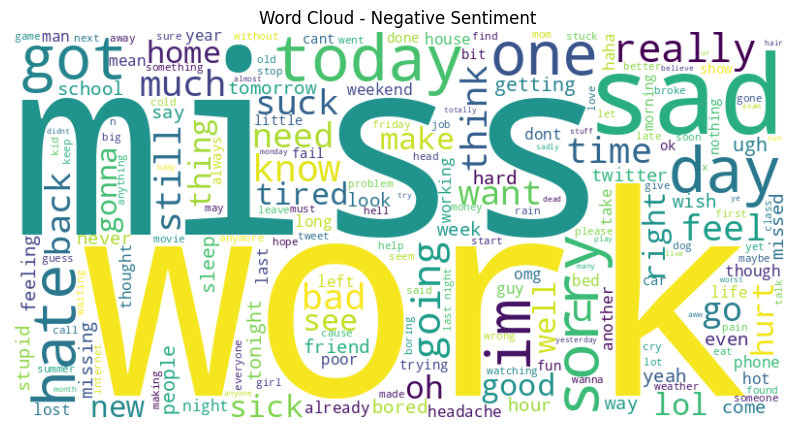

In [54]:
# Extract the text from negative sentiment tweets
negative_tweets = tweets_data[tweets_data["sentiment"] == "negative"]["cleaned_text"]

# Concatenate all the negative sentiment tweets into a single string
negative_text = " ".join(negative_tweets)

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color = "white").generate(negative_text)

# Plot the WordCloud
plt.figure(figsize = (10, 6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Word Cloud - Negative Sentiment")
plt.show()

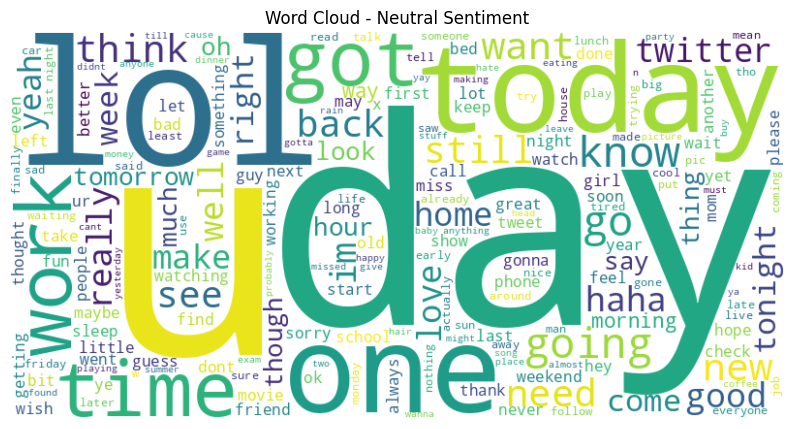

In [55]:
# Extract the text from neutral sentiment tweets
neutral_tweets = tweets_data[tweets_data["sentiment"] == "neutral"]["cleaned_text"]

# Concatenate all the neutral sentiment tweets into a single string
neutral_tweets = " ".join(neutral_tweets)

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color = "white").generate(neutral_tweets)

# Plot the WordCloud
plt.figure(figsize = (10, 6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Word Cloud - Neutral Sentiment")
plt.show()

Converting text labels to numeric form

In [56]:
tweets_data["sentiment"] = tweets_data["sentiment"].replace({"negative": 0, "neutral": 1, "positive": 2})

tweets_data.sample(10)

,text,sentiment,word_count,cleaned_text
8240,MILEEY HOW CAN I VOE IN THE MV MOVIE AWARDS ?,1,12,mileey voe mv movie awards
18620,"really ill again not been well for 2 weeks, i`...",0,15,really ill well weeks got bad viral infection
20957,I only saw urs by chance. Who else would have...,2,24,saw urs chance else would name think b missi...
4413,i miss you too,0,5,miss
5979,good luck with your auction,2,6,good luck auction
618,watched 100th episode of numb3rs. loved how th...,2,19,watched episode loved throwback first episode...
10487,Five o`clock can`t come any faster,1,6,five clock come faster
7646,I want to be like Horatio Caine,1,7,want like horatio caine
21408,You guys need to get on me. It`s been 2 weeks ...,1,20,guys need get weeks since went cache hunt ...
4817,I want noms,1,3,want noms


StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(tweets_data, test_size = 0.2, stratify = tweets_data["sentiment"], random_state = 123)
X_train, X_val = train_test_split(X_train, test_size = 0.1, stratify = X_train["sentiment"], random_state = 123)

X_train.shape, X_val.shape, X_test.shape

((19785, 4), (2199, 4), (5496, 4))

In [58]:
X_train["sentiment"].value_counts()

1    8005
2    6178
0    5602
Name: sentiment, dtype: int64

In [59]:
X_val["sentiment"].value_counts()

1    889
2    687
0    623
Name: sentiment, dtype: int64

In [60]:
X_test["sentiment"].value_counts()

1    2223
2    1717
0    1556
Name: sentiment, dtype: int64

Creating Training and validation dataset from corresponding pandas dataframes

In [63]:
raw_train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train["text"].values, X_train["sentiment"].values)).shuffle(1024).batch(batch_size = 128)

raw_val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val["text"].values, X_val["sentiment"].values)).batch(batch_size = 128)

raw_test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test["text"].values, X_test["sentiment"].values)).batch(batch_size = 128)

len(raw_train_ds), len(raw_val_ds), len(raw_test_ds)

(155, 18, 43)

Taking a simple example of small corpus, we are showing how count vectorizer works

In [64]:
vocab_size = 30

count_vectorizer = layers.TextVectorization(
    standardize = "lower_and_strip_punctuation",
    max_tokens = vocab_size,
    output_mode = "count",
)

In [65]:
# list of text documents
text = ["Malcolm is an amazing painter. Malcolm also loves watching cricket",
        "Dean cooks well",
        "Malcolm is a decent footballer too",
        "Chris is a teacher, he is quite experienced in teaching"]

Next, we are  calling adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

In [66]:
count_vectorizer.adapt(text)

In [67]:
count_vectorizer.get_vocabulary()

['[UNK]',
 'is',
 'malcolm',
 'a',
 'well',
 'watching',
 'too',
 'teaching',
 'teacher',
 'quite',
 'painter',
 'loves',
 'in',
 'he',
 'footballer',
 'experienced',
 'decent',
 'dean',
 'cricket',
 'cooks',
 'chris',
 'an',
 'amazing',
 'also']

Malcolm appearing twice in first doc.

In [68]:
count_vectorizer(text)

<tf.Tensor: shape=(4, 24), dtype=float32, numpy=
array([[0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 2., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)>

Next, we will create a TextVectorization layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the output_mode to count (Outputs a single int array per batch, of either vocab_size or max_tokens size,the int array contains a count of the number of times the token at that index appeared in the batch item.).

Note that you"re using the default split function, and the custom standardization function we defined above.

https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

In [69]:
vocab_size = 10000

count_vectorizer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "count",
    ngrams = (1, 2)
)

Next, we will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

In [70]:
# Make a text-only dataset (without labels), then call adapt

train_text = raw_train_ds.map(lambda x, y: x)

count_vectorizer.adapt(train_text)

Creating a function to see the result of using this layer to preprocess some data.

In [74]:
def vectorize_text(text, label):
    # Shape () => (1, )
    text = tf.expand_dims(text, -1)

    return count_vectorizer(text), label

Extracting  a batch of tweets and labels from the dataset and displaying an instance with tweet , label and output of applying text vectorizer to the tweet

In [75]:
import sys
np.set_printoptions(threshold = sys.maxsize)

class_names = ["negative", "neutral", "positive"]
text_batch, label_batch = next(iter(raw_train_ds))
first_tweet, first_label = text_batch[0], label_batch[0]

print("Tweet: ", first_tweet)
print("Sentiment: ", class_names[first_label])
print("Vectorized review: ", vectorize_text(first_tweet, first_label))

Tweet:  tf.Tensor(b'has a broken iphone', shape=(), dtype=string)
Sentiment:  negative
Vectorized review:  (<tf.Tensor: shape=(1, 10000), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [76]:
count_vectorizer.get_vocabulary()

['[UNK]',
 'day',
 'good',
 'get',
 'like',
 'go',
 'today',
 'love',
 'going',
 'work',
 'got',
 'one',
 'time',
 'lol',
 'know',
 'happy',
 'u',
 'really',
 'back',
 'im',
 'see',
 'night',
 'new',
 'home',
 'think',
 'want',
 'well',
 'oh',
 'much',
 'still',
 'thanks',
 'miss',
 'great',
 'last',
 'need',
 'morning',
 'haha',
 'hope',
 'would',
 'feel',
 'fun',
 'tomorrow',
 'sorry',
 'twitter',
 'wish',
 'bad',
 'make',
 'tonight',
 'sad',
 'right',
 'week',
 'yeah',
 'nice',
 'way',
 'mother',
 'gonna',
 'though',
 'better',
 'sleep',
 'could',
 'weekend',
 'come',
 'next',
 'people',
 'bed',
 'getting',
 'mothers',
 'wait',
 'watching',
 'mother day',
 'hate',
 'days',
 'say',
 'awesome',
 'thing',
 'school',
 'dont',
 'even',
 'mom',
 'soon',
 'yes',
 'long',
 'little',
 'show',
 'best',
 'working',
 'sure',
 'never',
 'ok',
 'thank',
 'done',
 'mothers day',
 'tired',
 'hey',
 'cool',
 'feeling',
 'take',
 'cant',
 'happy mother',
 'everyone',
 'look',
 'first',
 'please',
 'l

In [77]:
vocab_size =  len(count_vectorizer.get_vocabulary())

vocab_size

10000

Checking some instances of vocabulary

In [80]:
print("40   ---> ", count_vectorizer.get_vocabulary()[40])
print("80   ---> ", count_vectorizer.get_vocabulary()[80])
print("160  ---> ", count_vectorizer.get_vocabulary()[160])

40   --->  fun
80   --->  yes
160  --->  someone


Before training our model, As a final preprocessing step, we will apply the TextVectorization layer we created earlier to the train, validation, and test dataset.

In [81]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it"s loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files. The tf.data.Dataset.cache transformation can cache a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.

.prefetch() The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to tf.data.AUTOTUNE, which will prompt the tf.data runtime to tune the value dynamically at runtime.

In [82]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Model is defined which is simple Dense Neural network

In [83]:
dnn_model = Sequential([
    layers.Dense(64, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(32, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(3)
])

Model is compiled and summary is obtained. As activation=softmax is not defined inside the final dense layer we have to set logits=True

from_logits:Whether y_pred is expected to be a logits tensor. By default, we assume that y_pred encodes a probability distribution.

In [84]:
dnn_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.0001),
    metrics = ["accuracy"]
)

input_shape = (None, 10000)

dnn_model.build(input_shape)

dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 642243 (2.45 MB)
Trainable params: 642243 (2.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model is trained for 10 epochs

In [85]:
history = dnn_model.fit(
    train_ds,
    epochs = 10,
    validation_data = val_ds)

Epoch 1/10
155/155 [==============================] - 5s 15ms/step - loss: 1.0689 - accuracy: 0.4517 - val_loss: 1.0328 - val_accuracy: 0.4998
Epoch 2/10
155/155 [==============================] - 1s 5ms/step - loss: 0.9911 - accuracy: 0.5548 - val_loss: 0.9593 - val_accuracy: 0.5803
Epoch 3/10
155/155 [==============================] - 1s 5ms/step - loss: 0.8950 - accuracy: 0.6407 - val_loss: 0.8842 - val_accuracy: 0.6326
Epoch 4/10
155/155 [==============================] - 1s 5ms/step - loss: 0.7973 - accuracy: 0.6965 - val_loss: 0.8253 - val_accuracy: 0.6662
Epoch 5/10
155/155 [==============================] - 1s 5ms/step - loss: 0.7155 - accuracy: 0.7318 - val_loss: 0.7869 - val_accuracy: 0.6771
Epoch 6/10
155/155 [==============================] - 1s 5ms/step - loss: 0.6510 - accuracy: 0.7588 - val_loss: 0.7669 - val_accuracy: 0.6789
Epoch 7/10
155/155 [==============================] - 1s 5ms/step - loss: 0.5975 - accuracy: 0.7795 - val_loss: 0.7593 - val_accuracy: 0.6908
Epoch

Loss and accuracy is evaluated on test data

In [86]:
loss, accuracy = dnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 [==============================] - 1s 10ms/step - loss: 0.7946 - accuracy: 0.6778
Loss:  0.7945942282676697
Accuracy:  0.6777656674385071


Accuracy and Loss are plotted wrt epochs

In [87]:
history_dict = history.history

history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [88]:
history_dict

{'loss': [1.0689018964767456,
  0.9910643696784973,
  0.8949846625328064,
  0.7973105311393738,
  0.7154749035835266,
  0.6510090827941895,
  0.597484827041626,
  0.5538011193275452,
  0.5148158669471741,
  0.4823252260684967],
 'accuracy': [0.4516552984714508,
  0.5548142790794373,
  0.6407379508018494,
  0.6964872479438782,
  0.7318170070648193,
  0.7587566375732422,
  0.7794793844223022,
  0.7974728345870972,
  0.8134445548057556,
  0.8265352249145508],
 'val_loss': [1.0328099727630615,
  0.9593485593795776,
  0.8841940760612488,
  0.8253068327903748,
  0.7869246006011963,
  0.7668807506561279,
  0.759269118309021,
  0.7601785659790039,
  0.76798415184021,
  0.7798567414283752],
 'val_accuracy': [0.4997726380825043,
  0.5802637338638306,
  0.6325602531433105,
  0.6662119030952454,
  0.6771259903907776,
  0.6789449453353882,
  0.6907685399055481,
  0.6930422782897949,
  0.6866757869720459,
  0.6839472651481628]}

Model is overfitting after 7th epoch

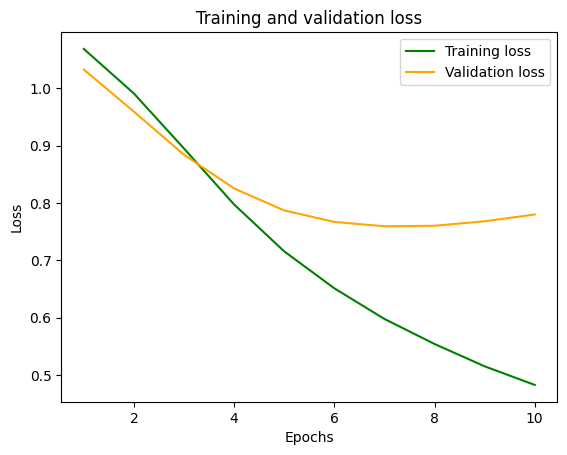

In [90]:
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

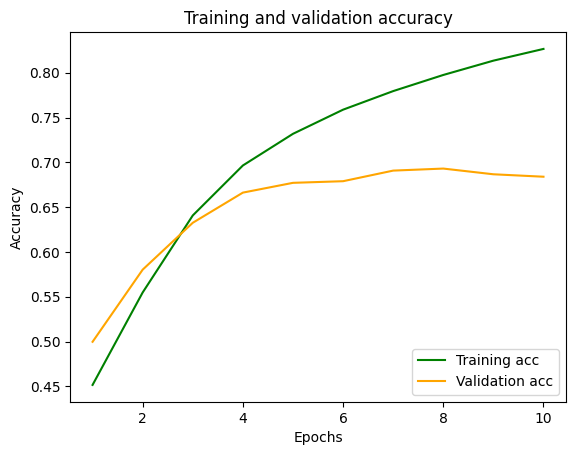

In [91]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In the training code above, we applied the TextVectorization layer to the dataset before feeding text to the model. If we want to make our  model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

In [92]:
export_model = Sequential([
  count_vectorizer,
  dnn_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.0001),
    metrics = ["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

43/43 [==============================] - 3s 21ms/step - loss: 0.7946 - accuracy: 0.6778
0.6777656674385071


Cross verifying obtained metrics using sklearn. Recall is bit lower for Negative class(0.61)

In [93]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                            classification_report

predictions = export_model.predict(X_test["text"].values)

y_pred = np.argmax(predictions , axis = 1)
y_test = X_test["sentiment"]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = None)
precision = precision_score(y_test, y_pred, average = None)
recall = recall_score(y_test, y_pred, average = None)

# Get the classification report
report = classification_report(y_test,y_pred)

# Print the classification report
print(report)

172/172 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      1556
           1       0.63      0.70      0.66      2223
           2       0.74      0.70      0.72      1717

    accuracy                           0.68      5496
   macro avg       0.69      0.67      0.68      5496
weighted avg       0.68      0.68      0.68      5496



Now we are using TF-IDF Vectorizer instead of Count vectorizer

Taking a simple corpus

In [94]:
vocab_size = 30

tfidf_vectorizer = layers.TextVectorization(
    standardize = "lower_and_strip_punctuation",
    max_tokens = vocab_size,
    output_mode = "tf-idf",
)

In [95]:
text = ["Malcolm is an amazing painter. Malcolm also loves watching cricket",
        "Dean cooks well",
        "Malcolm is a decent footballer too",
        "Chris is a teacher, he is quite experienced in teaching"]

In [96]:
tfidf_vectorizer.adapt(text)

In [97]:
tfidf_vectorizer.get_vocabulary()

['[UNK]',
 'is',
 'malcolm',
 'a',
 'well',
 'watching',
 'too',
 'teaching',
 'teacher',
 'quite',
 'painter',
 'loves',
 'in',
 'he',
 'footballer',
 'experienced',
 'decent',
 'dean',
 'cricket',
 'cooks',
 'chris',
 'an',
 'amazing',
 'also']

tf idf scores can be seen for each word in vocabulary for each document

In [98]:
tfidf_vectorizer(text)

<tf.Tensor: shape=(4, 24), dtype=float32, numpy=
array([[0.        , 0.6931472 , 1.6945957 , 0.        , 0.        ,
        1.0986123 , 0.        , 0.        , 0.        , 0.        ,
        1.0986123 , 1.0986123 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.0986123 , 0.        ,
        0.        , 1.0986123 , 1.0986123 , 1.0986123 ],
       [0.        , 0.        , 0.        , 0.        , 1.0986123 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.0986123 , 0.        , 1.0986123 ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.6931472 , 0.84729785, 0.84729785, 0.        ,
        0.        , 1.0986123 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.0986123 ,
        0.        , 1.0986123 , 0.        , 0.        , 0.        ,
        0.        , 0

Now we are defining our tfidf vectorizer with parameters. Note here we are taking ngrams in range (1,2)

In [99]:
vocab_size = 10000

tfidf_vectorizer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "tf-idf",
    ngrams = (1, 2)
)

tfidf_vectorizer.adapt(train_text)

Checking the entire vocabulary

In [ ]:
tfidf_vectorizer.get_vocabulary()

['[UNK]',
 'day',
 'good',
 'get',
 'like',
 'go',
 'today',
 'love',
 'going',
 'work',
 'got',
 'one',
 'time',
 'lol',
 'know',
 'happy',
 'u',
 'really',
 'back',
 'im',
 'see',
 'night',
 'new',
 'home',
 'think',
 'want',
 'well',
 'oh',
 'much',
 'still',
 'thanks',
 'miss',
 'great',
 'last',
 'need',
 'morning',
 'haha',
 'hope',
 'would',
 'feel',
 'fun',
 'tomorrow',
 'sorry',
 'twitter',
 'wish',
 'bad',
 'make',
 'tonight',
 'sad',
 'right',
 'week',
 'yeah',
 'nice',
 'way',
 'mother',
 'gonna',
 'though',
 'better',
 'sleep',
 'could',
 'weekend',
 'come',
 'next',
 'people',
 'bed',
 'getting',
 'mothers',
 'wait',
 'watching',
 'mother day',
 'hate',
 'days',
 'say',
 'awesome',
 'thing',
 'school',
 'dont',
 'even',
 'mom',
 'soon',
 'yes',
 'long',
 'little',
 'show',
 'best',
 'working',
 'sure',
 'never',
 'ok',
 'thank',
 'done',
 'mothers day',
 'tired',
 'hey',
 'cool',
 'feeling',
 'take',
 'cant',
 'happy mother',
 'everyone',
 'look',
 'first',
 'please',
 'l

Creating a function to see the result of using this tfidf vectorizer layer to preprocess some data.

In [ ]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return tfidf_vectorizer(text), label

Before training our model, As a final preprocessing step, we will apply the TextVectorization layer we created earlier to the train, validation, and test dataset.

In [100]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it"s loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

In [101]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Here same DNN is used but learning rate is decreased and model is trained for longer epochs(40)

In [102]:
dnn_model = Sequential([
    layers.Dense(64, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(32, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(3)
])

dnn_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.00001),
    metrics = ["accuracy"]
)

history = dnn_model.fit(
    train_ds,
    epochs = 40,
    validation_data = val_ds
)

Epoch 1/40
155/155 [==============================] - 2s 8ms/step - loss: 1.0927 - accuracy: 0.4056 - val_loss: 1.0874 - val_accuracy: 0.4202
Epoch 2/40
155/155 [==============================] - 1s 5ms/step - loss: 1.0855 - accuracy: 0.4296 - val_loss: 1.0814 - val_accuracy: 0.4393
Epoch 3/40
155/155 [==============================] - 1s 5ms/step - loss: 1.0794 - accuracy: 0.4445 - val_loss: 1.0758 - val_accuracy: 0.4466
Epoch 4/40
155/155 [==============================] - 1s 6ms/step - loss: 1.0729 - accuracy: 0.4580 - val_loss: 1.0703 - val_accuracy: 0.4561
Epoch 5/40
155/155 [==============================] - 1s 7ms/step - loss: 1.0669 - accuracy: 0.4692 - val_loss: 1.0647 - val_accuracy: 0.4643
Epoch 6/40
155/155 [==============================] - 1s 6ms/step - loss: 1.0590 - accuracy: 0.4829 - val_loss: 1.0589 - val_accuracy: 0.4716
Epoch 7/40
155/155 [==============================] - 1s 5ms/step - loss: 1.0514 - accuracy: 0.4954 - val_loss: 1.0529 - val_accuracy: 0.4820
Epoch 

Performance on test data has decreased from previous model with count vectorizer.

In [103]:
loss, accuracy = dnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 [==============================] - 0s 6ms/step - loss: 0.8429 - accuracy: 0.6507
Loss:  0.8428958654403687
Accuracy:  0.6506550312042236


Accuracy and Loss are plotted wrt epochs. Model is underfitting

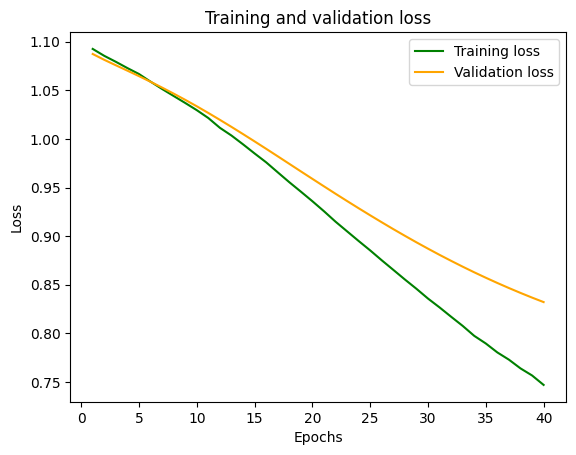

In [104]:
history_dict = history.history
history_dict.keys()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

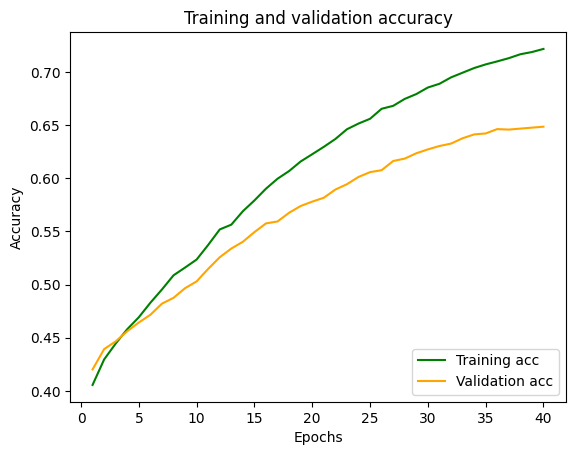

In [105]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In [106]:
export_model = Sequential([
  tfidf_vectorizer,
  dnn_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.00001),
    metrics = ["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

43/43 [==============================] - 1s 6ms/step - loss: 1.0084 - accuracy: 0.6141
0.6140829920768738


Defining a vectorized layer for training using Embedding layer. Steps will be repeated here too

"int": Outputs integer indices, one integer index per split string token. When output_mode == "int", 0 is reserved for masked locations; this reduces the vocab size to max_tokens - 2 instead of max_tokens - 1.

"output_sequence_length": Only valid in INT mode. If set, the output will have its time dimension padded or truncated to exactly output_sequence_length values, resulting in a tensor of shape (batch_size, output_sequence_length) regardless of how many tokens resulted from the splitting step. Defaults to None.

https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

In [107]:
vocab_size = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length
)

In [108]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [109]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

Before training our model, As a final preprocessing step, we will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [110]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it"s loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the data performance guide.

In [111]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

We are using a callback list here

Early stopping — Interrupting training when the validation loss is no longer improving (and save the best model obtained during training).
ReduceLROnPlateau-Dynamically adjusting the value of certain parameters during training such as the learning rate optimizer.
Tensorboard-Logging training and validation metrics during training or visualizing representations learned by the model as they’re updated. (The Keras progress bar we always see in our terminal during training!)

Callbacks are passed to the during via the callback argument in the fit() method which takes a list of callbacks. Any number of callbacks can be passed to it.

The monitor argument in the EarlyStopping callback monitor’s the model’s validation accuracy and the patience argument interrupts training when the parameter passed to the monitor argument stops improving for more than the number (of epochs) passed to it (in this case 3).

Also, the ReduceLROnPlateau callback is used to reduce the learning rate when the validation loss has stopped improving. This has proven to be a very effective strategy to get out of local minima during training. The factor argument takes as input a float which is used to multipy the learning rate when triggered.Factor by which the learning rate will be reduced. new_lr = lr * factor.

In [112]:
callback_list = [
    keras.callbacks.EarlyStopping(
        patience = 3,
        monitor = "val_accuracy"
    ),

    keras.callbacks.ReduceLROnPlateau(
        patience = 1,
        factor = 0.1,
    )
]

Neural network creation is started

The layers are stacked sequentially to build the classifier:

The first layer is an Embedding layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). To learn more about embeddings, check out the Word embeddings tutorial.
Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
The last layer is densely connected with a triple output node as there are 3 labels.

#### Embeddings
Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

#### GlobalAveragePooling1D

After passing through the embedding layer, you have a 3D tensor of shape (batch_size, sequence_length, embedding_dimension). GlobalAveragePooling1D compresses or reduces this 3D tensor into a 2D tensor. It does this by averaging over the sequence dimension (sequence_length), resulting in a 2D tensor of shape (batch_size, embedding_dimension). Essentially, it calculates the average of each embedding dimension across all words in the sequence.

Reduces Dimensionality: It simplifies the model by reducing the number of parameters, helping to mitigate overfitting.
Handles Variable Length Input: Useful in dealing with sentences of varying lengths, as it averages over the entire sequence length.
Captures Global Features: By averaging, it captures the essence of the entire input sequence, making it effective for tasks like document classification where the overall sentiment or theme is more important than the individual elements.

In [116]:
embedding_dim = 64

model = Sequential([
  layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dense(64, activation = "tanh"),
  layers.Dropout(0.1),
  layers.Dense(32, activation = "tanh"),
  layers.Dropout(0.1),
  layers.Dense(3)]
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          640000    
                                                                 
 dropout_6 (Dropout)         (None, None, 64)          0         
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                      

Note that the validation accuracy stalls and the learning rate is reduced by a factor of 10 (multiplied by 0.1)

In [117]:
model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
               loss = losses.SparseCategoricalCrossentropy(from_logits = True),
               metrics = ["accuracy"])

history = model.fit(
    train_ds,
    epochs = 50,
    validation_data = val_ds,
    callbacks = callback_list
)

Epoch 1/50
155/155 [==============================] - 11s 61ms/step - loss: 1.0866 - accuracy: 0.4024 - val_loss: 1.0870 - val_accuracy: 0.4043 - lr: 0.0010
Epoch 2/50
155/155 [==============================] - 1s 5ms/step - loss: 1.0385 - accuracy: 0.4549 - val_loss: 0.9227 - val_accuracy: 0.5716 - lr: 0.0010
Epoch 3/50
155/155 [==============================] - 1s 5ms/step - loss: 0.8033 - accuracy: 0.6467 - val_loss: 0.8299 - val_accuracy: 0.6594 - lr: 0.0010
Epoch 4/50
155/155 [==============================] - 1s 5ms/step - loss: 0.7083 - accuracy: 0.7052 - val_loss: 0.7856 - val_accuracy: 0.6812 - lr: 0.0010
Epoch 5/50
155/155 [==============================] - 1s 4ms/step - loss: 0.6544 - accuracy: 0.7356 - val_loss: 0.8023 - val_accuracy: 0.6853 - lr: 0.0010
Epoch 6/50
155/155 [==============================] - 1s 5ms/step - loss: 0.6037 - accuracy: 0.7695 - val_loss: 0.7894 - val_accuracy: 0.6885 - lr: 1.0000e-04
Epoch 7/50
155/155 [==============================] - 1s 5ms/ste

Peformance is slighly better than Model with TF_IDF vectorizer and is close to Model with Count vectorizer

In [118]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 [==============================] - 0s 2ms/step - loss: 0.7844 - accuracy: 0.6980
Loss:  0.7843812108039856
Accuracy:  0.6979621648788452


Accuracy and Loss are plotted wrt epochs. Model is overfitting

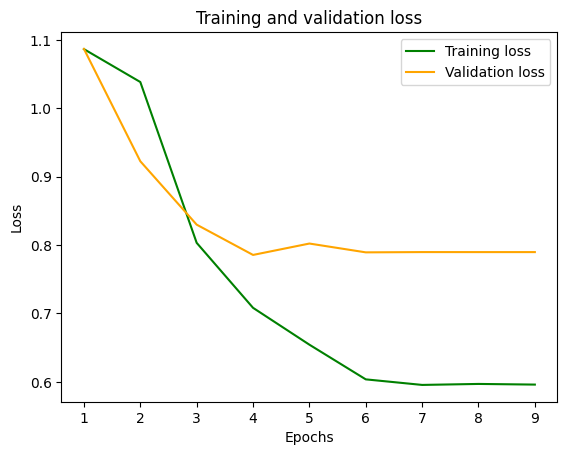

In [119]:
history_dict = history.history
history_dict.keys()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

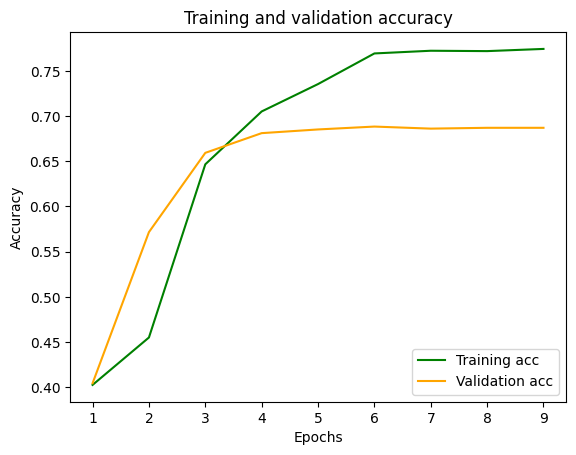

In [120]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

Now we will be training a more advanced neural network with RNNs. Steps will be repeated here too

We will train a simple RNN model.Model is overfitting after 3 epochs.Note that final layer has softmax activation defined so  the setting is "from_logits = False".

In [121]:
embedding_dim = 128

rnn_model = Sequential()

rnn_model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim))

rnn_model.add(layers.SimpleRNN(128, return_sequences = True))

rnn_model.add(layers.GlobalMaxPool1D())

rnn_model.add(layers.Dense(3, activation = "softmax"))

rnn_model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
               loss = losses.SparseCategoricalCrossentropy(from_logits = False),
               metrics = ["accuracy"])

history = rnn_model.fit(
    train_ds,
    epochs = 20,
    validation_data = val_ds, callbacks = callback_list)

Epoch 1/20
155/155 [==============================] - 44s 269ms/step - loss: 1.0097 - accuracy: 0.4845 - val_loss: 0.8620 - val_accuracy: 0.6139 - lr: 0.0010
Epoch 2/20
155/155 [==============================] - 38s 245ms/step - loss: 0.7191 - accuracy: 0.6950 - val_loss: 0.7605 - val_accuracy: 0.6817 - lr: 0.0010
Epoch 3/20
155/155 [==============================] - 34s 217ms/step - loss: 0.5277 - accuracy: 0.8012 - val_loss: 0.8211 - val_accuracy: 0.6730 - lr: 0.0010
Epoch 4/20
155/155 [==============================] - 35s 225ms/step - loss: 0.3805 - accuracy: 0.8722 - val_loss: 0.8010 - val_accuracy: 0.6758 - lr: 1.0000e-04
Epoch 5/20
155/155 [==============================] - 33s 215ms/step - loss: 0.3470 - accuracy: 0.8872 - val_loss: 0.7987 - val_accuracy: 0.6885 - lr: 1.0000e-05
Epoch 6/20
155/155 [==============================] - 35s 223ms/step - loss: 0.3410 - accuracy: 0.8893 - val_loss: 0.7984 - val_accuracy: 0.6876 - lr: 1.0000e-06
Epoch 7/20
155/155 [====================

In [122]:
loss, accuracy = rnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 [==============================] - 1s 20ms/step - loss: 0.8139 - accuracy: 0.6767
Loss:  0.8139206767082214
Accuracy:  0.676673948764801


Simple LSTM model is trained . Performance is marginally higher than our Count vectorizer +DNN model.

In [123]:
embedding_dim = 128

lstm_model = Sequential()

lstm_model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim))

lstm_model.add(layers.SpatialDropout1D(0.25))

lstm_model.add(layers.LSTM(128, dropout = 0.6, return_sequences = True))

lstm_model.add(layers.GlobalMaxPooling1D())

lstm_model.add(layers.Dense(32, activation = "tanh"))
lstm_model.add(layers.Dense(3, activation = "softmax"))

lstm_model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
               loss = losses.SparseCategoricalCrossentropy(from_logits = False),
               metrics = ["accuracy"])

history = lstm_model.fit(
    train_ds,
    epochs = 20,
    validation_data = val_ds, callbacks = callback_list)

Epoch 1/20
155/155 [==============================] - 15s 78ms/step - loss: 0.9351 - accuracy: 0.5422 - val_loss: 0.7650 - val_accuracy: 0.6780 - lr: 0.0010
Epoch 2/20
155/155 [==============================] - 3s 21ms/step - loss: 0.7138 - accuracy: 0.7016 - val_loss: 0.7208 - val_accuracy: 0.7058 - lr: 0.0010
Epoch 3/20
155/155 [==============================] - 4s 23ms/step - loss: 0.6205 - accuracy: 0.7506 - val_loss: 0.7243 - val_accuracy: 0.7071 - lr: 0.0010
Epoch 4/20
155/155 [==============================] - 3s 21ms/step - loss: 0.5286 - accuracy: 0.7991 - val_loss: 0.7298 - val_accuracy: 0.7126 - lr: 1.0000e-04
Epoch 5/20
155/155 [==============================] - 3s 21ms/step - loss: 0.5138 - accuracy: 0.8026 - val_loss: 0.7300 - val_accuracy: 0.7112 - lr: 1.0000e-05
Epoch 6/20
155/155 [==============================] - 3s 22ms/step - loss: 0.5133 - accuracy: 0.8035 - val_loss: 0.7298 - val_accuracy: 0.7112 - lr: 1.0000e-06
Epoch 7/20
155/155 [==============================]

In [124]:
loss, accuracy = lstm_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 [==============================] - 0s 8ms/step - loss: 0.7475 - accuracy: 0.7069
Loss:  0.7474575638771057
Accuracy:  0.7068777084350586


Accuracy score and Losses are shown wrt epochs. Model overfitting after 3 epochs

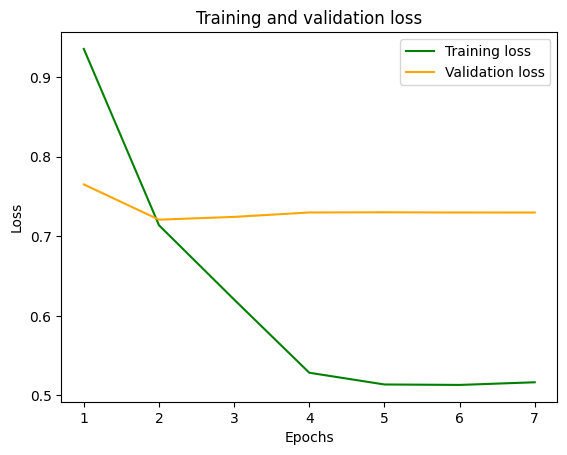

In [125]:
history_dict = history.history
history_dict.keys()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

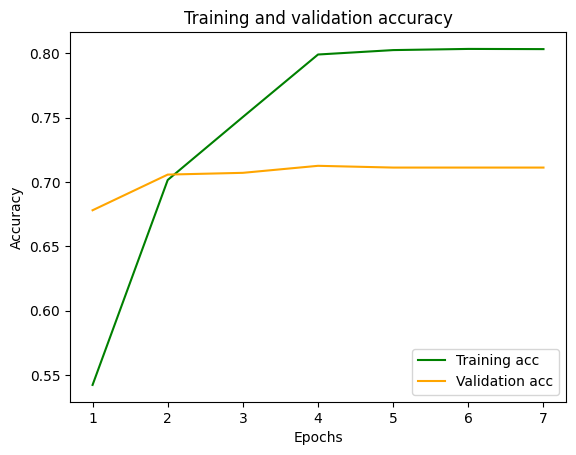

In [126]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In [127]:
export_model = Sequential([
  vectorize_layer,
  lstm_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = False),
    optimizer = optimizers.Adam(learning_rate = 0.001),
    metrics = ["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

43/43 [==============================] - 2s 16ms/step - loss: 0.7475 - accuracy: 0.7069
0.7068777084350586


We are doing inferencing on some examples and model predicting spam quite well. Note that keras3.0 does not work here

In [129]:
examples = [
  "this experience has been the worst, want my money back",
  "this AI related article is very good",
  "The movie was average" ]

export_model.predict(examples)

1/1 [==============================] - 0s 56ms/step


array([[0.9532099 , 0.04289653, 0.0038936 ],
       [0.02397307, 0.1877353 , 0.78829163],
       [0.25424364, 0.708109  , 0.03764731]], dtype=float32)

As we have already defined.."negative": 0, "neutral": 1, "positive": 2. So predictions makes sense

In [130]:
np.argmax(export_model.predict(examples), axis=1)

1/1 [==============================] - 0s 35ms/step


array([0, 2, 1])

Cross verifying metrics  with scikit-learn .
Recall for negative class seems to have improved . f1 score and accuracy improved for each class from our Count vectorizer+DNN model

In [131]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                            classification_report

predictions = export_model.predict(X_test["text"].values)
y_pred = np.argmax(predictions , axis = 1)

y_test = X_test["sentiment"]
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = None)
precision = precision_score(y_test,y_pred, average = None)
recall = recall_score(y_test,y_pred, average = None)

# Get the classification report
report = classification_report(y_test,y_pred)

# Print the classification report
print(report)

172/172 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.72      0.65      0.68      1556
           1       0.67      0.72      0.69      2223
           2       0.75      0.75      0.75      1717

    accuracy                           0.71      5496
   macro avg       0.71      0.70      0.71      5496
weighted avg       0.71      0.71      0.71      5496



Saving the trained model

In [132]:
lstm_model.save("sentiment_predictor.keras")

Loading the saved model and checking its performance

In [133]:
# Loading the saved model
loaded_model = models.load_model("sentiment_predictor.keras")
loss, accuracy = loaded_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 [==============================] - 1s 11ms/step - loss: 0.7475 - accuracy: 0.7069
Loss:  0.7474575638771057
Accuracy:  0.7068777084350586
